# Types of transfer learning
1. Original Model
2. Feature Extraction (when you don's have large enough data)
3. Fine-tuning (when you have more data than in feature extraction)

In [1]:
import torch
import torchvision

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


# Download previously written code

In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .   # Move files to current (.) directory
    !rm -rf pytorch-deep-learning   # Remove directories and their contents recursively (-r) and ignore nonexistent files and arguments, never prompt (-f)           
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3435, done.
remote: Total 3435 (delta 0), reused 0 (delta 0), pack-reused 3435
Receiving objects: 100% (3435/3435), 641.56 MiB | 17.66 MiB/s, done.
Resolving deltas: 100% (1975/1975), done.
Updating files: 100% (222/222), done.


In [4]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Prepare dataset for training model

## Get data

In [5]:
import requests
import os
import zipfile
from pathlib import Path

In [6]:
# Setup data path
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists, skipping re-download.")
else:
  print(f"Did not find {image_path}, downloading it...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Downlaod pizza_steak_sushi data
  with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print("Downloading pizza_steak_sushi data...")
    f.write(request.content)

  # Unzip the downloaded data
  with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print("Unzipping data...")
    zip_ref.extractall(image_path)
  
  # Remove the .zip file
  os.remove(data_path / 'pizza_steak_sushi.zip')

Did not find data/pizza_steak_sushi, downloading it...
Unzipping data...


In [7]:
# Setup directory path
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Create datasets and DataLoaders

### Create a transform for `torchvision.model` (manually)

In [8]:
BATCH_SIZE = 32

In [9]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transform = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       normalize])

In [10]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform = manual_transform,
    batch_size=BATCH_SIZE
)

In [11]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f0b8bb5fbe0>,
 ['pizza', 'steak', 'sushi'])

### Create a transform for `torchvision.model` (automatically)

In [12]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT means the best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [13]:
# Get the transform used to create our pretrained weights
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [14]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform = auto_transform,
    batch_size=BATCH_SIZE
)

In [15]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f0b8587a7f0>,
 ['pizza', 'steak', 'sushi'])

# Setup a pretrained model
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)

**Three things to consider:**
1. Speed
2. Size
3. Performance

## Import a base model

In [16]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [17]:
model.features # Extract features from image

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [18]:
model.avgpool # Turn features into a feature vector of smaller dimension

AdaptiveAvgPool2d(output_size=1)

In [19]:
model.classifier # Turn feature vector into prediction logits

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

## Get a summary of the model

In [20]:
# Print with torchinfo
summary(model=model,
        input_size=(1, 3, 224, 224), # An example of random image of [batch_size, coloe_channels, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

## Freeze base layer and update head

In [21]:
# Free all of the base layers in EffNetB0
for param in model.features.parameters():
  param.requires_grad = False

In [22]:
summary(model=model,
        input_size=(1, 3, 224, 224), # An example of random image of [batch_size, coloe_channels, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [23]:
# Update the classifier head of the model to suit our problem
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [24]:
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
).to(device)

In [25]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [26]:
summary(model=model,
        input_size=(1, 3, 224, 224), # An example of random image of [batch_size, coloe_channels, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

# Train the feature extractor model

In [27]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [28]:
# Set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer
end_time = timer()
print(f"The total training time: {(end_time-start_time):.4f} seconds.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8703 | train_acc: 0.7773 | test_loss: 0.7900 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.8008 | test_loss: 0.7433 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7114 | train_acc: 0.7578 | test_loss: 0.6344 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6252 | train_acc: 0.7930 | test_loss: 0.6238 | test_acc: 0.8864
The total training time: 17.2705 seconds.


# Evaluate by plotting the loss curve

In [29]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_functions.py, downloading...")
  !wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
  from helper_functions import plot_loss_curves

[INFO] Couldn't find helper_functions.py, downloading...
--2023-03-08 14:07:53--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10160 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.92K  --.-KB/s    in 0s      

2023-03-08 14:07:54 (97.4 MB/s) - ‘helper_functions.py’ saved [10160/10160]



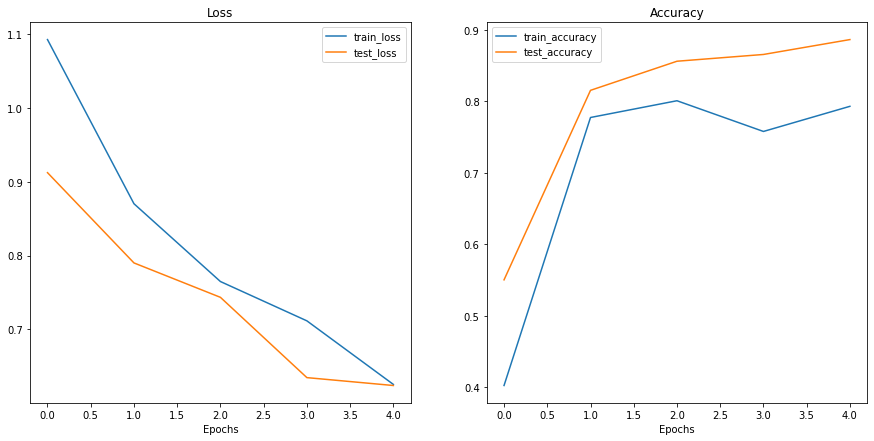

In [30]:
# Plot loss curves of our model
plot_loss_curves(results)

# Make predictions on images

## Predict the test images

In [31]:
from typing import List, Tuple
from PIL import Image

In [39]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  
  # Open the image with PIL
  image = Image.open(image_path)

  # Create a transform if one doesn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([transforms.Resize((224, 224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                std=[0.229, 0.224, 0.225])])
    
  # Make sure model is on target device
  model.to(device)

  # Turn on inference model and eval mode
  model.eval()
  with torch.inference_mode():
    # Transform the image and add an extra batch dimension
    transformed_image = image_transform(image).unsqueeze(dim=0)

    # Make a prediction on the transformed image, make sure the image is on target device
    target_image_score = model(transformed_image.to(device))
    # print(f"target_image_score: {target_image_score}")

    # Convert the predicted score into class
    target_image_pred_probs = torch.softmax(target_image_score, dim=1)
    # print(f"target_image_pred_probs: {target_image_pred_probs}")

    # Convert the pred_probs into pred labels
    target_image_pred_label = target_image_pred_probs.argmax(dim=1)
    # print(f"target_image_pred_label: {target_image_pred_label}")

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(image)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.2f}")
    plt.axis('off')

In [33]:
test_dir

PosixPath('data/pizza_steak_sushi/test')

In [34]:
Path(test_dir)

PosixPath('data/pizza_steak_sushi/test')

In [40]:
# Get a random list of image paths from the test set
import random
num_image_to_plot = 3
test_image_path_list = list(test_dir.glob('*/*.jpg'))
test_image_path_sample = random.sample(test_image_path_list, num_image_to_plot)
test_image_path_sample

[PosixPath('data/pizza_steak_sushi/test/sushi/46797.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg')]

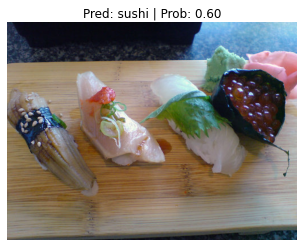

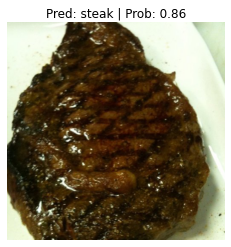

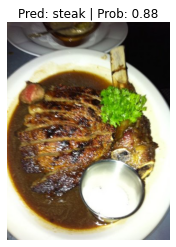

In [41]:
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names)

## Predict the custom image

In [42]:
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg

--2023-03-08 14:22:06--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.009s  

2023-03-08 14:22:07 (299 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



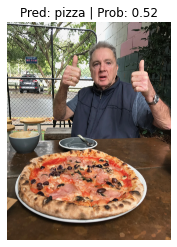

In [43]:
image_path = '/content/04-pizza-dad.jpeg'
pred_and_plot_image(model=model,
                    image_path=image_path,
                    class_names=class_names)

In [46]:
# Setup image path
custom_image_path = data_path / '01-pizza-dad.jpeg'

# Download the custom image
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')
    f.write(request.content)
else:
  print(f"Custom image {custom_image_path} already exists, skipping download.")

Custom image data/01-pizza-dad.jpeg already exists, skipping download.


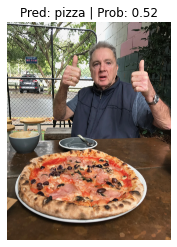

In [45]:
# Predict and plot
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)